In [1]:
import numpy as np
import pandas as pd
import sklearn

def generate_samples(n0, n1):
    x0 = np.vstack([
        np.random.normal(loc=[-3, -1], scale=0.6, size=(n0, 2)),
        np.random.normal(loc=[-1, 1], scale=0.4, size=(n0, 2))
    ])
    y0 = np.zeros(shape=(n0*2, 1))

    x1 = np.vstack([
        np.random.normal(loc=[-1, 1], scale=0.5, size=(n1, 2)),
        np.random.normal(loc=[2, 17], scale=10, size=(n1, 2)),
        np.random.normal(loc=[3, 1], scale=0.5, size=(n1, 2))
    ])
    y1 = np.ones(shape=(n1*3, 1))

    perm = np.random.permutation(len(y0))
    x0 = x0[perm]
    y0 = y0[perm]

    perm = np.random.permutation(len(y1))
    x1 = x1[perm]
    y1 = y1[perm]


    return (np.vstack([x0, x1]), np.concatenate([y0, y1]).ravel())


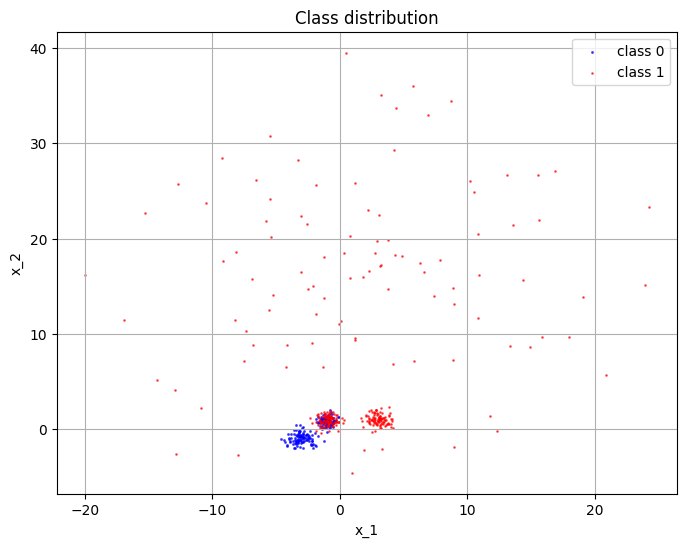

In [33]:
from matplotlib import pyplot as plt

def make_visual():
    X, y = generate_samples(100, 100)

    X0 = X[y == 0]
    X1 = X[y == 1]

    plt.figure(figsize=(8, 6))
    plt.scatter(X0[:, 0], X0[:, 1], color='blue', alpha=0.6, label='class 0', s=1.3)
    plt.scatter(X1[:, 0], X1[:, 1], color='red', alpha=0.6, label='class 1', s=0.9)
    plt.title("Class distribution")
    plt.xlabel("x_1")
    plt.ylabel("x_2")
    plt.legend()
    plt.grid(True)
    plt.show()

make_visual()

In [26]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

def estimate_metrics(model, i):
    x_train, y_train = generate_samples(100, 100)

    kfold_scores = 1 - cross_val_score(model, x_train, y_train, cv=5, scoring='accuracy')

    model.fit(x_train, y_train)
    emp_risk = 1 - accuracy_score(y_train, model.predict(x_train))

    x_test, y_test = generate_samples(10000, 10000)
    test_risk = 1 - accuracy_score(y_test, model.predict(x_test))

    return pd.Series([i, emp_risk, kfold_scores.mean(), test_risk])

def estimate_metrics_all(model, iterations=100):
    df = pd.DataFrame([estimate_metrics(model, i) for i in range(iterations)])
    df.columns = ['iteration', 'emp_risk', 'kfold_risk', 'test_risk']
    return df

def estimate_mean_metics(model, iterations=100):
    df_means = estimate_metrics_all(model, iterations).mean().drop('iteration')
    df_means.index = df_means.index + '_mean'
    df_dev = estimate_metrics_all(model, iterations).std().drop('iteration')
    df_dev.index = df_dev.index + '_std'
    df = pd.concat([df_means, df_dev], axis=0)
    return df

In [27]:
models_accuracy = pd.DataFrame(columns=['model', 'emp_risk_mean', 'kfold_risk_mean', 'test_risk_mean', 'emp_risk_std', 'kfold_risk_std', 'test_risk_std'])

def add_model(model, model_name, iterations=100):
    global models_accuracy

    s = estimate_mean_metics(model, iterations=iterations)
    s['model'] = model_name
    models_accuracy = pd.concat([models_accuracy, s.to_frame().T], ignore_index=True)
    return models_accuracy

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

add_model(LogisticRegression(), 'LogisticRegression')
add_model(DecisionTreeClassifier(), 'DecisionTreeClassifier')
add_model(DecisionTreeClassifier(max_depth=4), 'DecisionTreeClassifier_depth=4')
add_model(GradientBoostingClassifier(), 'GradientBoostingClassifier')
add_model(SVC(), 'SVC')

models_accuracy

,model,emp_risk_mean,kfold_risk_mean,test_risk_mean,emp_risk_std,kfold_risk_std,test_risk_std
0,LogisticRegression,0.2176,0.22138,0.219126,0.016563,0.016638,0.002138
1,DecisionTreeClassifier,0.0,0.20104,0.199764,0.0,0.017639,0.004689
2,DecisionTreeClassifier_depth=4,0.16016,0.19956,0.198119,0.016217,0.017523,0.007578
3,GradientBoostingClassifier,0.0316,0.19342,0.193961,0.006875,0.017956,0.004583
4,SVC,0.19504,0.20396,0.197163,0.009759,0.010129,0.003199


In [ ]:
from sklearn.ensemble import RandomForestClassifier

add_model(RandomForestClassifier(), 'RandomForestClassifier')
# add_model(GradientBoostingClassifier(n_estimators=500, learning_rate=0.01, max_depth=5), 'GradientBoostingClassifier_2')

,model,emp_risk,kfold_risk,test_risk
0,LogisticRegression,0.78076,0.77802,0.780999
1,DecisionTreeClassifier,1.0,0.79708,0.79951
2,DecisionTreeClassifier_depth=4,0.83894,0.7982,0.802016
3,GradientBoostingClassifier,0.96826,0.80344,0.805333
4,SVC,0.80608,0.79666,0.803616
5,RandomForestClassifier,0.99996,0.80334,0.806536
6,GradientBoostingClassifier_2,0.98178,0.80312,0.805837
